In [8]:
!pip install -q jax
!pip install -q flax
!pip install -q sentence_transformers
!pip install -q transformers


[notice] A new release of pip available: 22.3 -> 23.1.1
[notice] To update, run: python3 -m pip install --upgrade pip

[notice] A new release of pip available: 22.3 -> 23.1.1
[notice] To update, run: python3 -m pip install --upgrade pip

[notice] A new release of pip available: 22.3 -> 23.1.1
[notice] To update, run: python3 -m pip install --upgrade pip

[notice] A new release of pip available: 22.3 -> 23.1.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [9]:
## Importing stuff
import os 
os.environ['TOKENIZERS_PARALLELISM'] = "false"
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt

import transformers
from transformers import AutoTokenizer
from jax import numpy as jnp
import torch
from torchvision import datasets, transforms
from torchvision.transforms import CenterCrop, Normalize, Resize, ToTensor
from torchvision.transforms.functional import InterpolationMode
from tqdm.notebook import tqdm


In [ ]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|
    
    A token is already saved on your machine. Run `huggingface-cli whoami` to get more information or `huggingface-cli logout` if you want to log out.
    Setting a new token will erase the existing one.
    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: 

# Utils

In [10]:
# Setting up the model
# model = FlaxHybridCLIP.from_pretrained("clip-italian/clip-italian")
from transformers import FlaxVisionTextDualEncoderModel, VisionTextDualEncoderModel
model = FlaxVisionTextDualEncoderModel.from_pretrained("xx/xx", logit_scale_init_value=1,from_pt=True)
model.save_pretrained("arabic_clip") 

tokenizer = AutoTokenizer.from_pretrained(
    "asafaya/bert-base-arabic", cache_dir=None, use_fast=True
)

image_size = model.config.vision_config.image_size

preprocess = transforms.Compose([
    ToTensor(),
    Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711)),
])

Some weights of the model checkpoint at LinaAlhuri/clip-bert-proposed_lit_v2_freeze_mydata were not used when initializing FlaxVisionTextDualEncoderModel: {('vision_model', 'vision_model', 'embeddings', 'position_ids'), ('text_model', 'embeddings', 'position_ids')}
- This IS expected if you are initializing FlaxVisionTextDualEncoderModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing FlaxVisionTextDualEncoderModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [11]:
# defining necessary functions

def pad_to_square(image, size=224):
    old_size = image.size
    ratio = float(size) / max(old_size)
    new_size = tuple([int(x * ratio) for x in old_size])
    image = image.resize(new_size, Image.ANTIALIAS)
    new_image = Image.new("RGB", size=(size, size), color=(128, 128, 128))
    new_image.paste(image, ((size - new_size[0]) // 2,
                        (size - new_size[1]) // 2))
    return new_image


def text_encoder(text):
    inputs = tokenizer([text], max_length=96, truncation=True, padding="max_length", return_tensors="np")
    embedding = model.get_text_features(inputs['input_ids'], inputs['attention_mask'])[0]
    embedding /= jnp.linalg.norm(embedding)
    return embedding


def image_encoder(image):
    image = np.transpose(image, (0, 2, 3, 1))
    features = model.get_image_features(image)
    features /= jnp.linalg.norm(features, keepdims=True)
    return features


def gen_image_batch(path, image_size=224, pixel_size=10):

    n_pixels = image_size // pixel_size + 1

    image_batch = []
    masks = []

    image = Image.open(path).convert("RGB")
    image = pad_to_square(image, size=image_size)
    gray = np.ones_like(image) * 128
    mask = np.ones_like(image)


    image_batch.append(image)
    masks.append(mask)


    for i in range(0, n_pixels):
        for j in range(i+1, n_pixels):
            m = mask.copy()
            m[:min(i*pixel_size, image_size) + 1, :] = 0
            m[min(j*pixel_size, image_size) + 1:, :] = 0
            neg_m = 1 - m
            image_batch.append(image * m + gray * neg_m)
            masks.append(m)

    for i in range(0, n_pixels+1):
        for j in range(i+1, n_pixels+1):
            m = mask.copy()
            m[:, :min(i*pixel_size + 1, image_size)] = 0
            m[:, min(j*pixel_size + 1, image_size):] = 0
            neg_m = 1 - m
            image_batch.append(image * m + gray * neg_m)
            masks.append(m)

    return image_batch, masks


def get_heatmap(image_path, text, pixel_size=10, iterations=3):
    text_embedding = text_encoder(text)
    images, masks = gen_image_batch(image_path, pixel_size=pixel_size)

    images = np.stack([preprocess(image) for image in images], axis=0)
    image_embeddings = jnp.asarray(image_encoder(images))
    
    sims = []
    scores = []
    mask_val = jnp.zeros_like(masks[0])

    for e, m in zip(image_embeddings, masks):
        sim = jnp.matmul(e, text_embedding.T)
        sims.append(sim)
        if len(sims) > 1:
            scores.append(sim * m)
            mask_val += 1-m

    score = jnp.mean(jnp.clip(jnp.array(scores) - sims[0], 0, jnp.inf), axis=0)
    for i in range(iterations):
        score = jnp.clip(score - jnp.mean(score), 0, jnp.inf)
    score = (score - jnp.min(score)) / (jnp.max(score) - jnp.min(score))
    return np.asarray(score)


def display_heatmap(image, text, heatmap):
    fig = plt.figure(figsize=(15, 30), facecolor='white')
    ax1 = fig.add_subplot(131)
    ax2 = fig.add_subplot(132)
    ax3 = fig.add_subplot(133)

    ax1.imshow(image)
    ax2.imshow(heatmap)
    ax3.imshow(np.asarray(image) / 255. * heatmap)

    ax1.axis('off')
    ax2.axis('off')
    ax3.axis('off')

    ax1.title.set_text('input image')
    ax2.title.set_text(text)

    plt.tight_layout()

    plt.show()

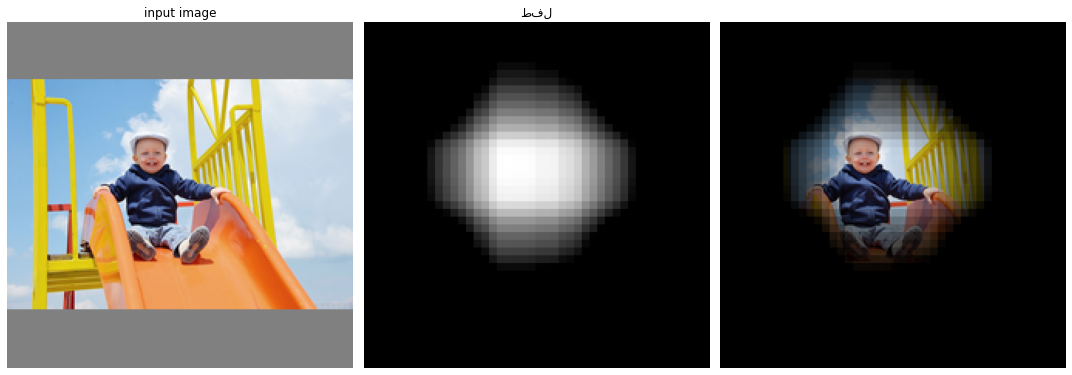

In [12]:
# pass the model a URL of an image that you would like it to analyze
url = 'https://www.froddo.com/media/blog/playground/child_slide.jpg'

# add the italian description of an object that you would like the model to find in the image
query = 'طفل'

!wget -q -O ./image {url}

image = Image.open('./image').convert("RGB")
image = pad_to_square(image, size=224)

heatmap = get_heatmap('./image', query, pixel_size=5, iterations=3)

display_heatmap(image, query, heatmap)

In [ ]:
# Execute to look at image batch that is used to generat the heatmap

# images, masks = gen_image_batch('image', pixel_size=50)

# for im in images:
#     plt.imshow(im)
#     plt.show()